# Data exploration for Land-Use-Land-Cover analysis 

This notebook consists of preliminary steps for data accessing and exploration towards constructing a machine learning pipeline for predicting the land use and land cover for the region of interest. We will use satellite images obtained by ESA's Sentinel-2 through the whole process of creating the pipeline, with details provided at each step.

## Before you start

### Requirements

In order to run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://www.sentinel-hub.com/trial). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, please configure the `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your `oauth` client id and secret. Also you can find this [guide ](https://docs.sentinel-hub.com/api/latest/user-guides/beginners-guide/)useful. 

### Overview


Define the Area-of-Interest (AOI):
   * Obtain the outline of AOI
   * Split into manageable smaller tiles

Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package to download with some content (band data, cloud masks, ...)
   * Define the time interval for the data we want to access


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We install first the SentinelHub as a major dependencies and we install other dependancies sucu as matplotlib and numpy

In [2]:
!pip install sentinelhub
!pip install matplotlib
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.1/244.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.7 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6109 sha256=178fa64d46677e31a21686d23177408bc6a8bca21e6cc7562c91dc56cabac968
  Stored in directory: /root/.cache/pip/wheels/75/f0/dd/39dfc9436520412399934d4a8566fe5c0cb8cc2568a1196057
Successfully built utm
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load dependencies

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import getpass

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SHConfig
)


Credential

Process API requires Sentinel Hub account. Use your CliendID and ClientSecret 

In [5]:
# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = input("Enter your Sentinel Hub client ID: ")
CLIENT_SECRET = getpass.getpass("Enter your Sentinel Hub client secret: ")

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

KeyboardInterrupt: ignored

Explain data and why buffer was added


## Define the Area-of-Interest (AOI):

We will download Sentinel-2 imagery of Rwamagana.

The bounding box in WGS84 coordinate system is (30.425992,-1.965438,30.445819,-1.944636) (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.


Set the bounding box of the area of interest (AOI): Make sure you select an area of interest based on the SentinelHub account type you have. Note that free accounts alow limited data access.

In [ ]:
rwamagana_town = (30.425992,-1.965438,30.445819,-1.944636)

When the bounding box bounds have been defined, you can initialize the BBox of the area of interest. Using the bbox_to_dimensions utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape

In [ ]:
resolution = 10
rwamagana_bbox = BBox(bbox=rwamagana_town, crs=CRS.WGS84)
rwamagana_size = bbox_to_dimensions(rwamagana_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {rwamagana_size} pixels")

Image shape at 10 m resolution: (220, 230) pixels


The evalscript is written in the Sentinel Hub scripting language, which is a modified version of JavaScript. The scripting language provides a set of predefined functions and variables that can be used to manipulate and analyze the satellite data.

In the context of downloading Sentinel-2 images using Sentinel Hub, the evalscript is used to perform image processing tasks such as cloud masking, atmospheric correction, and band combinations. It allows users to customize the way that satellite data is processed to meet their specific needs.

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-06-21", "2022-06-21"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=rwamagana_bbox,
    size=rwamagana_size,
    config=config,
)

In [ ]:
true_color_imgs = request_true_color.get_data()

In [ ]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (230, 220, 3)


In [ ]:
def plot_image(image, factor, clip_range):
    plt.imshow(factor * image.squeeze(), vmin=clip_range[0], vmax=clip_range[1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

Image type: uint8


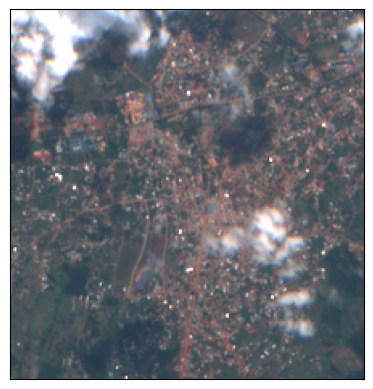

In [ ]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

**Adding cloud mask data**

It is also possible to obtain cloud masks when requesting Sentinel-2 data by using the cloud mask band (CLM) or the cloud probabilities band (CLP). 

The factor for increasing the image brightness can already be provided in the evalscript.

In [ ]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLM"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLM == 1) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-06-21", "2022-06-21"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=rwamagana_bbox,
    size=rwamagana_size,
    config=config,
)

In [ ]:
data_with_cloud_mask = request_true_color.get_data()

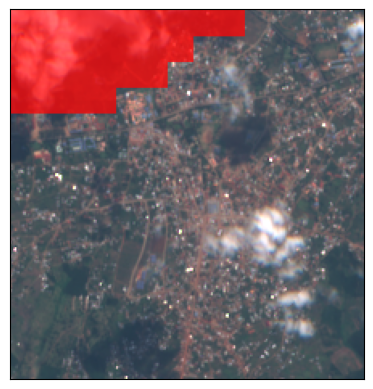

In [ ]:
plot_image(data_with_cloud_mask[0], factor=1 / 255, clip_range=(0,1))

**True color mosaic of least cloudy acquisitions**


The SentinelHubRequest automatically creates a mosaic from all available images in the given time interval. By default, the mostRecent mosaicking order is used. More information available here.

In this example we will provide a 3 months long interval, order the images according to the least cloud coverage on the tile level (leastCC parameter), and mosaic them in the specified order.

In [ ]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-06-01", "2022-08-31"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=rwamagana_bbox,
    size=rwamagana_size,
    config=config,
)

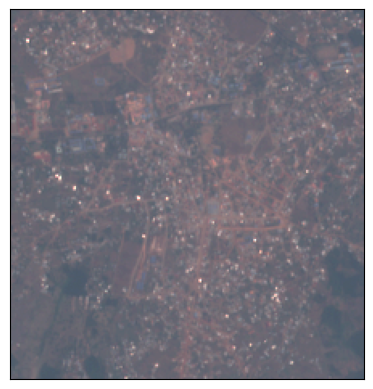

In [ ]:
plot_image(request_true_color.get_data()[0], factor=3.5 / 255, clip_range=(0, 1))

**Accessing all Sentinel-2’s raw band values**

Now let’s define an *evalscript* which will return all Sentinel-2 spectral bands with raw values.

In this example we are downloading already quite a big chunk of data, so optimization of the request is not out of the question. Downloading raw digital numbers in the INT16 format instead of reflectances in the FLOAT32 format means that much less data is downloaded, which results in a faster download and a smaller usage of SH processing units.

In order to achieve this, we have to set the input units in the evalscript to DN (digital numbers) and the output sampleType argument to INT16. Additionally, we can’t pack all Sentinel-2’s 13 bands into a PNG image, so we have to set the output image type to the TIFF format via MimeType.TIFF in the request.

The digital numbers are in the range from 0-10000, so we have to scale the downloaded data appropriately.

In [ ]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-06-01", "2022-08-31"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=rwamagana_bbox,
    size=rwamagana_size,
    config=config,
)

In [ ]:
all_bands_response = request_all_bands.get_data()

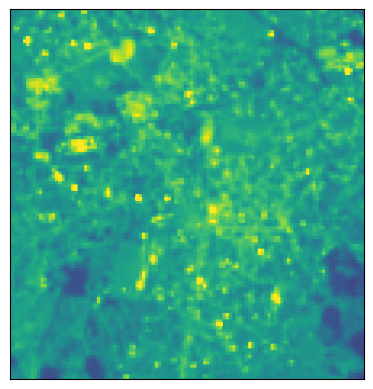

In [ ]:
# Image showing the SWIR band B12
# Factor 1/1e4 due to the DN band values in the range 0-10000
# Factor 3.5 to increase the brightness
plot_image(all_bands_response[0][:, :, 12], factor=3.5 / 1e4, clip_range = (0, 1))

From raw bands we can also construct a False-Color images

RGB (8,4,3)

False color imagery is displayed in a combination of standard near infra-red, red and green band. False color composite using near infrared, red and green bands is very popular. It is most commonly used to assess plant density and healht, as plants reflect near infrared and green light, while absorbing red. Since they reflect more near infrared than green, plant-covered land appears deep red. Denser plant growth is darker red. Cities and exposed ground are gray or tan, and water appears blue or black.

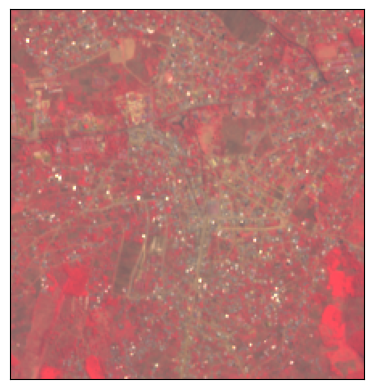

In [ ]:

# False color image is (B03, B04, B08)
plot_image(all_bands_response[0][:, :, [7, 3, 2]], factor=3.5 / 1e4, clip_range=(0, 1))

Agriculture
RGB (11,8,2)

This composite, often called the Agriculture RGB composite, uses bands SWIR-1 (B11), near-infrared (B08) and blue (B02). It’s mostly used to monitor crop health, as both short-wave and near infrared bands are particularly good at highlighting dense vegetation, which appears dark green in the composite. SWIR measurements can help scientists estimate how much water is present in plants and soil, as water reflects SWIR light. Shortwave-infrared bands are also useful for distinguishing between snow, and ice, all of which appear white in visible light. Newly burned land reflects strongly in SWIR bands, making them valuable for mapping fire damage.

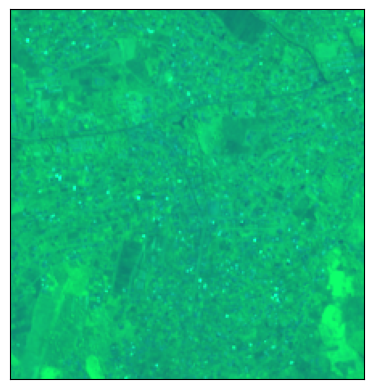

In [ ]:

# False color image is (B02, B08, B11)
plot_image(all_bands_response[0][:, :, [10, 7, 1]], factor=3.5 / 1e4, clip_range=(0, 1))

##<font color=yellow>Question 5.1.1:</font>  
Complete the code below to visualize the color composite with (B02, B03, B04).

True color composite uses visible light bands red (B04), green (B03) and blue (B02) in the corresponding red, green and blue color channels, resulting in a natural colored result, that is a good representation of the Earth as humans would see it naturally.

In [ ]:
# COMPLETE CODE HERE BY REPLACING FILL-IN
#plot_image(FILL-IN, factor=3.5 / 1e4, clip_range=(0, 1))

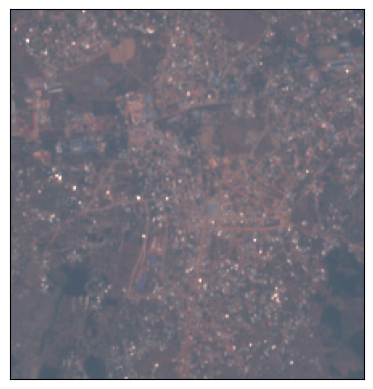

In [ ]:
#ANSWER
# True color image is (B02, B03, B03)
plot_image(all_bands_response[0][:, :, [3, 2, 1]], factor=3.5 / 1e4, clip_range=(0, 1))

# **Multiple timestamps data**

It is possible to construct some logic in order to return data for multiple timestamps. By defining the time_interval parameter and some logic of splitting it, it is possible to create an SH reques per each “time slot” and then download the data from all the requests with the SentinelHubDownloadClient in sentinelhub-py. In this example we will create least cloudy monthly images for the year 2022.

However, this is already a functionality built on top of this SH API package. This functionality has been extended for such usage in the eo-learn package. It is recommended to use eo-learn for more complex cases where you need multiple timestamps or high-resolution data for larger areas.

In [ ]:
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2022, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2022-01-01', '2022-01-29')
('2022-01-29', '2022-02-26')
('2022-02-26', '2022-03-26')
('2022-03-26', '2022-04-23')
('2022-04-23', '2022-05-21')
('2022-05-21', '2022-06-18')
('2022-06-18', '2022-07-16')
('2022-07-16', '2022-08-13')
('2022-08-13', '2022-09-10')
('2022-09-10', '2022-10-08')
('2022-10-08', '2022-11-05')
('2022-11-05', '2022-12-03')


In [ ]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=rwamagana_bbox,
        size=rwamagana_size,
        config=config,
    )

In [ ]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [ ]:
# Plots
ncols = 4
nrows = 3
aspect_ratio = rwamagana_size[0] / rwamagana_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()